In [38]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time

In [39]:
def next_batch(data_tr, i, batch_size):
    return data_tr[i*batch_size:(i+1)*batch_size-1, :]  

# Parameters
n_tr = 50
n_val = 50
learning_rate = 0.02
num_epochs = 4000
batch_size = n_tr // 1
itpep = n_tr // batch_size
# display_step = 100
# snap_step = 1000
wd_par = 0.0

# Network Parameters
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 1 
num_output = 1 

# tf Graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
X_bc = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])
Y_bc = tf.placeholder(tf.float32, shape = [None, 1])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

In [40]:
# Create model
def NN(x):
    # Hidden fully connected layer
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer 
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

u = NN(X)
u_bc = NN(X_bc)

def NN_d(u, x):
        dudx = tf.gradients(u, x)[0]
        return dudx

dudx = NN_d(u, X)

In [41]:
error_u_point = tf.math.sqrt(tf.pow(u-Y, 2) / tf.pow(Y, 2))
error_u_sum = tf.reduce_sum(tf.pow(u-Y, 2)) / tf.cast(tf.size(Y), float)
error_dudx = tf.reduce_sum(tf.pow(dudx-Y, 2)) / tf.cast(tf.size(Y), float)

loss = tf.reduce_sum(tf.pow(dudx-Y, 2)) / tf.cast(tf.size(Y), float) \
                + tf.reduce_sum(tf.pow(u_bc-Y_bc, 2)) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [25]:
sess = tf.Session()
sess.run(init)

locs = np.random.uniform(0, 10, n_tr).reshape(-1,1)
data_tr = np.concatenate((locs, np.cos(locs)), axis =1)

locs = np.random.uniform(0, 10, n_val).reshape(-1,1)
data_val = np.concatenate((locs, np.cos(locs)), axis =1)

training_loss = [sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]], X_bc: [[0]], Y_bc: [[0]]})]
validation_error = [sess.run(error_dudx, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]

i = 0

itpep = data_tr.shape[0] // batch_size
tic = time.perf_counter()

for iteration in range(num_epochs * itpep):
    
    locs = np.random.uniform(0, 10, n_tr).reshape(-1,1)
    data_tr = np.concatenate((locs, np.cos(locs)), axis =1)
     
    data_batch = next_batch(data_tr, i, batch_size)
    sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]], X_bc: [[0]], Y_bc: [[0]]})
    
    if (iteration + 1) % itpep == 0:
        i = 0
        training_loss.append(sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]], X_bc: [[0]], Y_bc: [[0]]}))
        validation_error.append(sess.run(error_dudx, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))
    else:
        i += 1
    
#     if (iteration + 1) % (display_step * itpep) == 0 or iteration == 0:
#         loss_disp = sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
#         print("Epoch:", '%04d' % ((iteration + 1) // itpep), "loss=", "{:.9f}".format(loss_disp))

toc = time.perf_counter()

print("Optimization Finished!")

Optimization Finished!


Run in 9.1903 seconds


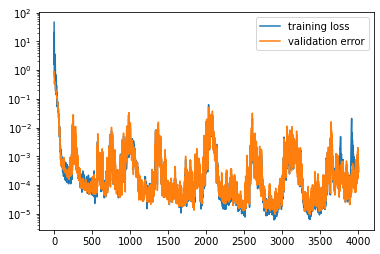

In [26]:
print(f"Run in {toc - tic:0.4f} seconds")

plt.yscale('log')
plt.plot(np.arange(len(training_loss)), training_loss, label = 'training loss')
plt.plot(np.arange(len(training_loss)), validation_error, label = 'validation error')
plt.legend()
plt.show()

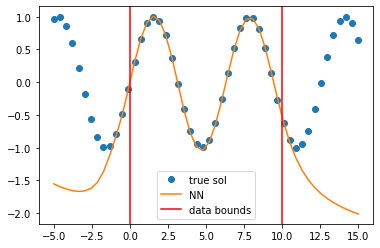

In [27]:
x = np.linspace(-5, 15, 50)
plt.plot(x, np.sin(x), 'o', label = 'true sol')
plt.plot(x, sess.run(u, feed_dict = {X:[[v] for v in x]}), label = 'NN')
plt.axvline(x=0, label = 'data bounds', color = 'r')
plt.axvline(x=10, color = 'r')
plt.legend()
plt.show()

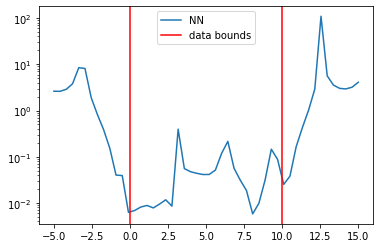

In [28]:
x = np.linspace(-5, 15, 50)
plt.yscale('log')
plt.plot(x, sess.run(error_u_point, feed_dict={X: x.reshape(-1,1), Y: np.sin(x).reshape(-1,1)}), label = 'NN')
plt.axvline(x=0, label = 'data bounds', color = 'r')
plt.axvline(x=10, color = 'r')
plt.legend()
plt.show()

In [42]:
loss = tf.reduce_sum(tf.pow(u-Y, 2)) / tf.cast(tf.size(Y), float)  \
                + tf.reduce_sum(tf.pow(u_bc-Y_bc, 2)) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [43]:
sess = tf.Session()
sess.run(init)

locs = np.random.uniform(0, 10, n_tr).reshape(-1,1)
data_tr = np.concatenate((locs, np.sin(locs)), axis =1)

locs = np.random.uniform(0, 10, n_val).reshape(-1,1)
data_val = np.concatenate((locs, np.sin(locs)), axis =1)

training_loss = [sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]], X_bc: [[0]], Y_bc: [[0]]})]
validation_error = [sess.run(error_u_sum, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]})]

i = 0

itpep = data_tr.shape[0] // batch_size
tic = time.perf_counter()

for iteration in range(num_epochs * itpep):
     
    data_batch = next_batch(data_tr, i, batch_size)
    sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]], X_bc: [[0]], Y_bc: [[0]]})
    
    if (iteration + 1) % itpep == 0:
        i = 0
        training_loss.append(sess.run(loss, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]], X_bc: [[0]], Y_bc: [[0]]}))
        validation_error.append(sess.run(error_u_sum, feed_dict={X: data_val[:, [0]], Y: data_val[:, [1]]}))
    else:
        i += 1
    
#     if (iteration + 1) % (display_step * itpep) == 0 or iteration == 0:
#         loss_disp = sess.run(loss, feed_dict={X: data_tr[:, [0]], Y: data_tr[:, [1]]})
#         print("Epoch:", '%04d' % ((iteration + 1) // itpep), "loss=", "{:.9f}".format(loss_disp))

toc = time.perf_counter()

print("Optimization Finished!")

Optimization Finished!


Run in 6.6881 seconds


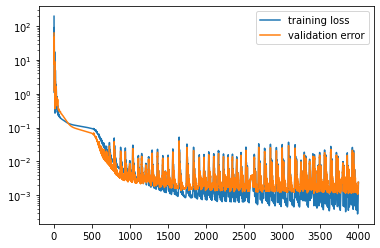

In [44]:
print(f"Run in {toc - tic:0.4f} seconds")

plt.yscale('log')
plt.plot(np.arange(len(training_loss)), training_loss, label = 'training loss')
plt.plot(np.arange(len(training_loss)), validation_error, label = 'validation error')
plt.legend()
plt.show()

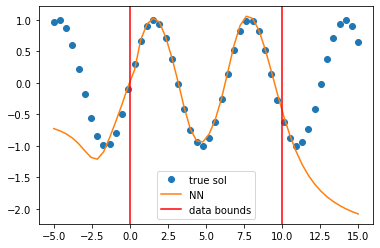

In [45]:
x = np.linspace(-5, 15, 50)
plt.plot(x, np.sin(x), 'o', label = 'true sol')
plt.plot(x, sess.run(u, feed_dict = {X:[[v] for v in x]}), label = 'NN')
plt.axvline(x=0, label = 'data bounds', color = 'r')
plt.axvline(x=10, color = 'r')
plt.legend()
plt.show()

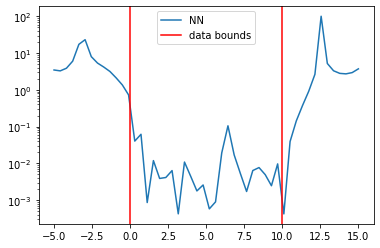

In [37]:
x = np.linspace(-5, 15, 50)
plt.yscale('log')
plt.plot(x, sess.run(error_u_point, feed_dict={X: x.reshape(-1,1), Y: np.sin(x).reshape(-1,1)}), label = 'NN')
plt.axvline(x=0, label = 'data bounds', color = 'r')
plt.axvline(x=10, color = 'r')
plt.legend()
plt.show()